1. download whole checking history
2. download this month's cc history, overlapping days
3. change FINAL_MONTH and checking_df import 

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BONUS_THRESH = 4_000

START_BALANCE = 10896.91

FINAL_YEAR, FINAL_MONTH, FINAL_DAY = 2024, 9, 30

In [9]:
checking_df

,Details,Posting Date,Description,Amount,Type,Balance,Check or Slip #
0,DEBIT,10/03/2024,ORIG CO NAME:LPCRESIDENT3-225 CO ENTRY DESCR:W...,-3931.00,ACH_DEBIT,,NaN
1,DEBIT,10/03/2024,ORIG CO NAME:VENMO CO ENTRY DESCR:P...,-8.35,ACH_DEBIT,,NaN
2,DEBIT,10/03/2024,ORIG CO NAME:VENMO CO ENTRY DESCR:P...,-1.06,ACH_DEBIT,,NaN
3,DEBIT,10/03/2024,ORIG CO NAME:VENMO CO ENTRY DESCR:P...,-7.57,ACH_DEBIT,,NaN
4,DEBIT,10/02/2024,VENMO PAYMENT 1037285656114 WE...,-1.06,ACH_DEBIT,12625.45,NaN
...,...,...,...,...,...,...,...
706,DEBIT,10/03/2022,WHOLEFDS RVR 101 340 R CAMBRIDGE MA 136216 1...,-66.72,DEBIT_CARD,7480.87,NaN
707,DEBIT,10/03/2022,BLUEBIKES MERCHANTACCOU CA 1...,-3.13,DEBIT_CARD,7547.59,NaN
708,DEBIT,10/03/2022,TST* FELIPE'S TAQUERIA CAMBRIDGE MA 1...,-11.48,DEBIT_CARD,7550.72,NaN
709,DEBIT,10/03/2022,UBER TRIP HELP.UBER.COM CA 1...,-10.47,DEBIT_CARD,7562.20,NaN


In [10]:
# if starting over
credit_chase_dfs = [
    pd.read_csv(f"data/chase/{path}") for path in os.listdir("data/chase/") if path.startswith("Chase3098")
]
# credit_capital_one_dfs = [pd.read_csv(f"data/capital_one/{path}") for path in os.listdir("data/capital_one/")]
# credit_dfs = # TODO align column names to the chase ones
credit_df = pd.concat(credit_chase_dfs).reset_index()

# if adding new
# credit_df = pd.read_csv("data\chase\Chase3098_Activity20240817_20240902_20240902.CSV", index_col=False)

credit_df = credit_df.drop("Transaction Date", axis="columns")
credit_df = credit_df.rename({"Post Date": "Posting Date"}, axis="columns")
credit_df["Posting Date"] = pd.to_datetime(credit_df["Posting Date"])

checking_df = pd.read_csv("data\chase\Chase7113_Activity_20241003.CSV", index_col=False)
checking_df["Posting Date"] = pd.to_datetime(checking_df["Posting Date"])
checking_df = checking_df.sort_values("Posting Date")

# Start from Sept 2022 (first stable post-moving month)
credit_df = credit_df[credit_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]
checking_df = checking_df[checking_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]

# End at last month
credit_df = credit_df[credit_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=FINAL_YEAR)]
checking_df = checking_df[
    checking_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=FINAL_YEAR)
]

# process
checking_df = checking_df[checking_df["Type"] != "MISC_DEBIT"]
checking_df["Balance"] = checking_df.Balance.astype(np.float64)


# Add month col for grouping
credit_df["month"] = pd.to_datetime(
    credit_df["Posting Date"].dt.year.astype(str) + "-" + credit_df["Posting Date"].dt.month.astype(str)
)
checking_df["month"] = pd.to_datetime(
    checking_df["Posting Date"].dt.year.astype(str) + "-" + checking_df["Posting Date"].dt.month.astype(str)
)

### 1. Prep debit expenses table

In [11]:
debit_df = checking_df[checking_df.Amount < 0]

# ignore credit card payments, since they double count cc expenses
cc_pay_keywords = ["Payment to Chase card", "CHASE CREDIT CRD"]
debit_df = debit_df[~pd.DataFrame([debit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 2. Prep credit expenses table

In [12]:
# drop cc payments
cc_pay_keywords = ["Returned Payment", "Payment Thank You", "AUTOMATIC PAYMENT - THANK"]
credit_df = credit_df[~pd.DataFrame([credit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 3. Prep income table

In [13]:
income_df = checking_df[checking_df.Amount > 0]

# partition out paychecks
paycheck_df = income_df[income_df.Description.str.contains("MICROSOFT")]
income_df = income_df.drop(paycheck_df.index, axis=0)

# separate bonuses from paychecks
bonus_rows = []
for i, (idx, row) in enumerate(paycheck_df.iterrows()):
    if row.Amount > 4_000:
        # get bonus amount by comparing to surrounding paychecks
        if (i + 1 < len(paycheck_df)) and paycheck_df.iloc[i + 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i + 1].Amount
        elif i != 0 and paycheck_df.iloc[i - 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i - 1].Amount
        else:
            raise Exception("no valid paycheck to compare")

        # update paycheck_df
        paycheck_df.loc[idx, "Amount"] -= bonus_amt

        bonus_row = row.copy()
        row.Amount = bonus_amt

        # save bonus row
        bonus_rows.append(row)
bonus_df = pd.DataFrame(bonus_rows)

# partition out stocks (+ other random bonus looking things)
stock_keywords = ["SCHWAB", "NORTH LANE", "REAL TIME TRANSFER", "Morgan", "IRS", "COMM.", "FID"]
stock_df = income_df[pd.DataFrame([income_df.Description.str.contains(kw) for kw in stock_keywords]).any(axis=0)]

# remaining things are refunds related to specific expenses
refund_df = income_df.drop(stock_df.index)

# income line items
income_dfs = [paycheck_df, bonus_df, stock_df, refund_df]

del income_df

## Update categories

In [16]:
# debit_df + credit_df - refund_df
expense_df = pd.concat([debit_df, credit_df]).reset_index().drop(columns="level_0")
expense_df["Category"] = None
expense_df_prev_categories = pd.read_csv("expense.csv", index_col=0)
expense_df_prev_categories = (
    expense_df_prev_categories.sort_values(["Posting Date", "Description", "Amount"], inplace=False)
    .reset_index()
    .drop(columns="level_0")
)

expense_df = (
    expense_df.sort_values(["Posting Date", "Description", "Amount"], inplace=False)
    .reset_index()
    .drop(columns="level_0")
)
expense_df.loc[: len(expense_df_prev_categories), "Category"] = expense_df_prev_categories["Category"]
del expense_df_prev_categories

In [17]:
nontypical_expense_keywords = ["SCHWAB", "TAXPY"]
expense_df_nontypical = expense_df[
    pd.DataFrame([expense_df.Description.str.contains(kw) for kw in nontypical_expense_keywords]).any(axis=0)
]
expense_df_typical = expense_df.drop(expense_df_nontypical.index)

In [18]:
net_df = pd.concat([expense_df] + income_dfs).sort_values("Posting Date")

In [19]:
expense_df_typical_monthly = -expense_df_typical.groupby("month").Amount.sum()
expense_df_nontypical_monthly = -expense_df_nontypical.groupby("month").Amount.sum()
expense_df_monthly = -expense_df.groupby("month").Amount.sum()

In [20]:
cat_instructions = """1. Bills
2. Grocery
3. Necessary meals
4. Social food/drinks
5. Transit
6. Travel
7. Entertainment
8. Venmo
9. Shopping
10. Clothing
11. Haircut
12. Medical
13. Exercise
14. Medication
15. Subscriptions
16. Investments"""
rules = {
    "Bills": ["bozzuto", "eversource", "xfinity", "comcast", "lpcresi"],
    "Grocery": ["brothers", "wholef"],
    "Necessary meals": [
        "chipotle",
        "aceituna",
        "uber   eats",
        "doordash",
        "subway",
        "oxxo",
        "bon me",
        "tatte",
        "cava",
        "postmat",
        "mcdona",
        "instacar",
        "dunkin",
        "chowbus",
    ],
    "Social food/drinks": [
        "zuma",
        "bar taco",
        "conces",
        "cask 'n",
        "shy bird",
        "harp",
        "phoenix",
        "flat top",
        "cheeky",
    ],
    "Transit": ["mta", "mbta", "uber   trip", "lime", "bluebike", "beam", "uber *trip", "lim*ride", "bixi"],
    "Travel": ["airbnb", "united", "amtrak", "delta", "zipcar toll", "zipcar trip", "zipcar extend", "zipcar late"],
    "Entertainment": [
        "ticketmaster",
        "gametime",
        "stubhub",
        "tickpick",
        "lucky strike",
        "golf",
        "seatgeek",
        " ski",
        "ski ",
    ],
    "Venmo": ["venmo"],
    "Shopping": ["amazon", "target", "amzn"],
    "Clothing": [],
    "Haircut": [],
    "Medical": ["colleen", "willems", "bspt", "dds"],
    "Exercise": ["usta", "volo"],
    "Medication": ["pharmacy"],
    "Subscriptions": ["zipcar monthly", "mlb.tv", "relayforre"],
    "Investments": ["schwab"],
}
rules_map = {}
for cat, vals in rules.items():
    for val in vals:
        rules_map[val] = cat
num_map = [cat for cat in rules.keys()]

for i in range(len(expense_df)):
    # expense_df.iloc[i, expense_df.columns.get_loc("Category")] = None
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is not None:
        continue
    for key in rules_map.keys():
        if key in expense_df.iloc[i]["Description"].lower():
            expense_df.iloc[i, expense_df.columns.get_loc("Category")] = rules_map[key]
            break
    print(
        expense_df.iloc[i, expense_df.columns.get_loc("Description")],
        expense_df.iloc[i, expense_df.columns.get_loc("Category")],
    )

VENMO            PAYMENT    1036979698074   WEB ID: 3264681992 Venmo
VENMO            PAYMENT    1036979859230   WEB ID: 3264681992 Venmo
CHIPOTLE 1615 Necessary meals
TST* ACEITUNA CAFE Necessary meals
VTG*Elizabeth A. Willems  Medical
Zipcar Monthly Plan Subscriptions
Subway 31620 Necessary meals
VENMO            PAYMENT    1037020017884   WEB ID: 3264681992 Venmo
VENMO            PAYMENT    1037020095832   WEB ID: 3264681992 Venmo
WHOLEFDS CAM 10010 Grocery
BA INFLIGHT SALES None
FANPASS None
GLOUCESTER ARMS None
GLOUCESTER ARMS None
HUDSON ST2416 None
The Arts Theatre Club None
The Arts Theatre Club None
BAR SOHO LONDON None
BAR SOHO LONDON None
DOG &amp; DUCK None
LA BRIOCHE None
Lucy Wong None
Lucy Wong None
ROYAL ALBERT HALL None
ROYAL ALBERT HALL None
Royal Albert Hall None
Royal Albert Hall None
Royal Albert Hall None
TFL TRAVEL CH None
TFL TRAVEL CH None
UBER   *TRIP None
ZETTLE_*IVS GROUP LIMI None
ZETTLE_*PHOENIX STAFFI Social food/drinks
Arcade None
Disrepute None
FLYING H

In [21]:
print("Left:", expense_df["Category"].isna().sum())
print(expense_df["Description"][expense_df["Category"].isna()].tolist())

Left: 66
['VENMO            PAYMENT    1036979528750   WEB ID: 3264681992', 'BA INFLIGHT SALES', 'FANPASS', 'GLOUCESTER ARMS', 'GLOUCESTER ARMS', 'HUDSON ST2416', 'The Arts Theatre Club', 'The Arts Theatre Club', 'BAR SOHO LONDON', 'BAR SOHO LONDON', 'DOG &amp; DUCK', 'LA BRIOCHE', 'Lucy Wong', 'Lucy Wong', 'ROYAL ALBERT HALL', 'ROYAL ALBERT HALL', 'Royal Albert Hall', 'Royal Albert Hall', 'Royal Albert Hall', 'TFL TRAVEL CH', 'TFL TRAVEL CH', 'UBER   *TRIP', 'ZETTLE_*IVS GROUP LIMI', 'Arcade', 'Disrepute', 'FLYING HORSE', 'GLOUCESTER ARMS', 'SUMUP  *WHITE RABBIT PHOT', 'TFL TRAVEL CH', 'TFL TRAVEL CH', 'TFL TRAVEL CH', 'UBER   *TRIP', 'TFL TRAVEL CH', 'Duke of Wellington', 'Duke of Wellington', 'FEZ MANGAL', 'GAILS - NOTTING HILL', 'GAILS - NOTTING HILL', 'AXS.COMBOWERY NY', 'POSTCARD TEAS', 'RESERVED', 'TFL TRAVEL CH', 'TFL TRAVEL CH', 'The 411', 'The 411', 'UBER* TRIP', 'Zettle_*FREEBRIGHTS LTD', 'KSG DUBLIN AIRPORT', 'TFL TRAVEL CH', 'DEVITTS OF CAMDEN ST 01', 'DEVITTS OF CAMDEN ST

In [23]:
from IPython.display import clear_output

print("Left:", expense_df["Category"].isna().sum())
for i in range(len(expense_df)):
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is None:
        print(
            expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
            expense_df.iloc[i, expense_df.columns.get_loc("Description")],
            expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
        )
        print(cat_instructions)
        try:
            cat_idx = int(input()) - 1  # zero index!
        except:
            clear_output()
            print(
                expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
                expense_df.iloc[i, expense_df.columns.get_loc("Description")],
                expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
            )
            print(cat_instructions)
            try:
                cat_idx = int(input()) - 1  # zero index!
            except:
                clear_output()
                print(
                    expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
                    expense_df.iloc[i, expense_df.columns.get_loc("Description")],
                    expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
                )
                print(cat_instructions)
                cat_idx = int(input()) - 1  # zero index!
        clear_output()
        expense_df.iloc[i, expense_df.columns.get_loc("Category")] = num_map[cat_idx]

In [24]:
expense_df.to_csv("expense.csv")

In [25]:
net_worth_df = pd.DataFrame(
    [df.groupby("month").Amount.sum() for df in income_dfs],
    index=["Paycheck", "Bonus", "Stock/Tax Return", "Misc/Refund"],
).T

net_worth_df["Typical Expenses"] = -expense_df_typical_monthly
net_worth_df["Atypical Expenses"] = -expense_df_nontypical_monthly
net_worth_df = net_worth_df.fillna(0)

In [26]:
net_worth_df

,Paycheck,Bonus,Stock/Tax Return,Misc/Refund,Typical Expenses,Atypical Expenses
month,,,,,,
2022-10-01,5668.49,0.00,0.00,585.11,-6463.45,0.0
2022-11-01,5668.52,0.00,0.00,2311.96,-8376.50,0.0
2022-12-01,5668.50,0.00,0.00,69.00,-3600.33,0.0
2023-01-01,6283.90,0.00,0.00,20.05,-9824.01,0.0
2023-02-01,5770.38,0.00,12034.33,0.00,-7271.65,-4212.0
2023-03-01,5757.47,0.00,0.00,146.27,-9032.51,0.0
2023-04-01,5757.46,2672.89,0.00,511.60,-6657.78,0.0
2023-05-01,5757.50,0.00,0.00,633.00,-7301.57,0.0
2023-06-01,5757.48,0.00,0.00,0.00,-8397.89,0.0


In [27]:
expense_df.groupby("Category")["Amount"].sum().sort_values()

Category
Social food/drinks   -48338.51
Necessary meals      -41943.03
Entertainment        -24272.88
Shopping             -21860.41
Transit              -19675.52
Travel               -11610.67
Venmo                -10783.22
Medication            -8953.45
Bills                 -8168.29
Subscriptions         -8157.22
Grocery               -6267.78
Clothing              -1980.10
Medical               -1721.94
Exercise               -496.79
Investments            -312.51
Haircut                 -51.19
Name: Amount, dtype: float64

In [28]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum())

month
2022-10-01    10687.06
2022-11-01    10291.04
2022-12-01    12428.21
2023-01-01     8908.15
2023-02-01    15229.21
2023-03-01    12100.44
2023-04-01    14384.61
2023-05-01    13473.54
2023-06-01    10833.13
2023-07-01    16554.73
2023-08-01    13845.67
2023-09-01    11528.33
2023-10-01     9688.91
2023-11-01     7766.96
2023-12-01     7439.57
2024-01-01     6473.75
2024-02-01     5710.42
2024-03-01     5313.72
2024-04-01     5333.15
2024-05-01     2620.30
2024-06-01     5873.38
2024-07-01     2166.27
2024-08-01     3129.89
2024-09-01     9735.14
Freq: MS, dtype: float64

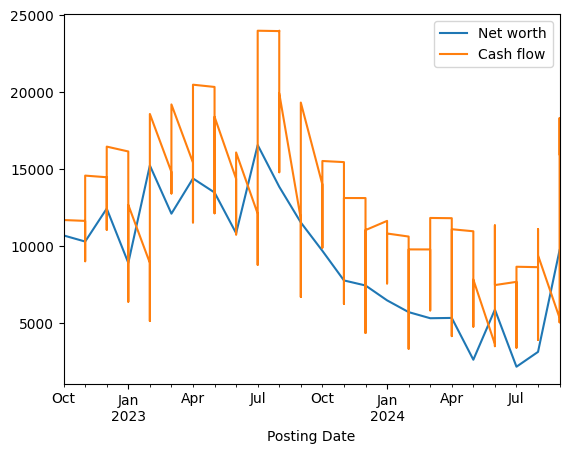

In [29]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum()).plot()
(START_BALANCE + checking_df.groupby("Posting Date").Amount.sum().cumsum()).plot()
plt.legend(["Net worth", "Cash flow"])

## this month's spending

In [30]:
def compare_medians(medians: pd.Series, expense_df: pd.DataFrame):
    this_month_expense_df = expense_df[
        expense_df["month"] == datetime.datetime(day=1, month=FINAL_MONTH, year=FINAL_YEAR)
    ]
    this_month_categories = -this_month_expense_df.groupby("Category").Amount.sum().sort_values()

    # plot this month as a % diff from medians
    pct_diff = ((this_month_categories - medians) / medians) * 100
    print(pct_diff.sort_values(ascending=False))

    # look at the expenses from top few categories
    for cat in pct_diff.sort_values(ascending=False).index[:3]:
        print(cat)
        print(
            this_month_expense_df[this_month_expense_df["Category"] == cat][["Description", "Amount"]].sort_values(
                "Amount"
            )
        )

In [31]:
# same month prev years
same_month_expense_df = expense_df[
    (expense_df["month"].dt.month == FINAL_MONTH) & (expense_df["month"].dt.year != FINAL_YEAR)
]
same_month_category_medians = (
    -same_month_expense_df.groupby(["Category", "month"]).Amount.sum().groupby("Category").median().sort_values()
)
compare_medians(same_month_category_medians, expense_df)

# last 12 months
last_12_months_expense_df = expense_df[
    expense_df["month"] >= datetime.datetime(day=1, month=FINAL_MONTH, year=FINAL_YEAR) - pd.DateOffset(months=12)
]
last_12_months_category_medians = (
    -last_12_months_expense_df.groupby(["Category", "month"]).Amount.sum().groupby("Category").median().sort_values()
)
compare_medians(last_12_months_category_medians, expense_df)

Category
Medical               1701.277139
Entertainment         1551.560254
Venmo                  529.526494
Clothing               381.809995
Necessary meals        118.734797
Social food/drinks      97.349733
Bills                  -55.751191
Subscriptions          -73.243618
Grocery                -82.406636
Medication             -90.843336
Shopping               -92.672165
Transit                -97.424721
Travel                -126.450503
Exercise                      NaN
Name: Amount, dtype: float64
Medical
                    Description  Amount
2456  VTG*Elizabeth A. Willems  -203.06
2386  BROTHERS MARKETPLACE #404  -25.66
2381     AMAZON MKTPL*ZT8P97QU2  -23.34
2385               Subway 27428  -17.01
2388       Amazon.com*ZT6ZO0QP0  -13.01
Entertainment
                                            Description   Amount
2360  LPCRESIDENT3-225 WEB PMTS   1J6XZG          WE... -3956.00
2463                                            FANPASS  -498.25
2475                         